## Tariff Data for Gudat & Weldzius (2015)

This notebook analysis tariff data for Canada, Mexico, and the US from different data sources

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

Set user to ensure files are imported from correct filepath:

In [2]:
user = "tew207"  # set this variable to tew207 or rweldzius

The basic structure of the data set is determined by the variables `year`, `industries` and `countries`. As our unit of observation will be a country-pair/industry combination, it is worthwhile to add an observation identifier at this level.

We will create a `DataFrame` object holding the panel in long format:

In [3]:
years = np.arange(1981, 2013)
industries = ['15', '17', '20', '21', '23', '26', '27', '28', '36']
countries = ["can", "mex", "usa"]
pairs = ["can-mex","can-usa","mex-can","mex-usa","usa-can","usa-mex"]
group_industryid = np.arange(1, len(industries)*len(countries)+1)
industry = [np.repeat(industries,len(years))]*3
industry = list(it.chain(industry[0],industry[1],industry[2]))
year = list(it.chain.from_iterable([years]*27))
obs_id = np.repeat(group_industryid, len(years))

<h3> US Tariff Data - USITC and John Romalis</h3>

The US tariff data comes from the <a href="http://www.usitc.gov/tariff_affairs/tariff_databases.htm">US International Trade Commission</a>, where a complete archive of 8-digit tariff lines is available from 1997 up to 2015. The definition of variables used in the archives can be found <a href = "http://pubapps2.usitc.gov/tariff/tariff_layout.jsp">here</a>.

Additionally, we use data from John Romalis' tariff database, available <a href = "http://www.johnromalis.com/downloads/TariffL.ZIP">here</a>, which has the advantage of already including estimated ad-valorem equivalen tariff rates for Canadian and Mexican imports. Since this data is only available for the years 1989 to 2001, we have to calculate the AVE rates ourselves from USITC data for the years 2002 to 2015.

Start by reading in the data from USITC (Note that there is some issue with the 2010 data, but skipping one of the thousands of tariff lines shouldn't hurt us):

In [4]:
path = "/Users/"+user+"/Dropbox/Trade Paper/Data/Raw/Tariffs/Romalis Tariff Data/"
usitc = pd.read_csv(path+"USHTS2002.txt", sep = "\t")
usitc['year'] = 2002

for i in range(2003,2013):
    temp = pd.read_csv(path+"USHTS"+str(i)+".txt", sep = "\t", error_bad_lines=False, low_memory=False)
    temp['year'] = i
    usitc = usitc.append(temp)

Skipping line 770: expected 33 fields, saw 34



The USITC data from 1989 to 2001 has been made available by John Romalis, with the added benefit of having estimated Ad-Valorem equivalent tariffs. We import the data, noting that the 2001 data set has a somewhat different format and extra columns, which will be dropped:

In [5]:
jrt = pd.read_csv(path+"USHTS1989.txt", sep = "\t")
for i in range(1990,2001):
    jrt = jrt.append(pd.read_csv(path+"USHTS"+str(i)+".txt", sep = "\t"), ignore_index=True)

jrt01 = pd.read_csv(path+"USHTS2001.txt", sep = "\t", low_memory=False)
jrt01 = jrt01.drop(list(set(jrt01.columns)-set(jrt.columns)), 1)
jrt = jrt.append(jrt01, ignore_index=True)

Next, we drop some of the columns that are not needed. A complete list of variables can be found in <a href = "http://www.nber.org/papers/w9387.pdf">Feenstra, Romalis & Schott (2002)</a>, starting on page 30 of the pdf.

In [6]:
to_keep = ['hts8', 'year', 'brief_description', 'mfn_rate_type_code', 'mfn_ave', 'mfn_ad_val_rate', 'mfn_specific_rate',
           'mfn_other_rate', 'canada_ave', 'canada_ad_val_rate', 'canada_specific_rate', 'canada_other_rate', 
           'mexico_rate_type_code', 'mexico_ave', 'mexico_ad_val_rate', 'mexico_specific_rate', 'mexico_other_rate']
           
jrt = jrt[to_keep]
usitc = usitc[list(set(usitc.columns).intersection(set(to_keep)))]

One other weird feature of the dataset is that the year variable is coded as 89, 90,... for some industries but 1989, 1990,... for others. To make sure that we don't miss any data when we select by year, let's unify the treatment of the year 
variable so that all years are coded in 4-digit format:

In [7]:
yrlong = np.arange(1989,2000)
yrshort = np.arange(89,100)
for i, j in zip(yrlong,yrshort):
    jrt.year.replace(j, i, inplace=True)

Then we want to exclude those tariff lines that belong to products produced outside of our selection of industries. For this, we have to consult the <a href = "http://hts.usitc.gov/">Harmonized Tariff Schedule</a> website. Obviously the HTS categorization does not line up perfectly with our industry classification, but let's proceed for the moment with the following simplified classification: we want to include in our dataset everything in:

   1. Section IV: Food, Beverages, Tobacco
   2. Section V: Mineral Products
   3. Section VI: Products of Chemical or Allied Industries
   4. Section VII: Plastics and Rubber
   5. Section VIII: Leather and Leather Products
   6. Section IX: Wood and Articles of Wood
   7. Section X: Paper and Printing
   8. Section XI: Textiles and Textile Articles
   9. Section XII: Footwear, Headgear etc
   10. Section XIII: Stone, Glass, Cement
   12. Section XV: Base Metals
   13. Section XVI: Machinery and Electrical Equipment
   14. Section XVII: Transportation Equipment
   15. Section XVIII: Optical, Photographic, Medical Equipment
   17. Section XX: Miscellaneous

This would require us to use tariffs in categories 16 to 70, 72 to 92 and 94 to 96. The variable HTS8, which gives the HTS code of products, is stored as integers, so we can simply pick the relevant parts of the dataset by size comparisons:

In [8]:
exclude = range(int(93e6),int(94e6)) + range(int(71e6),int(72e6))
jrt = jrt[(jrt.hts8<97e6) & (jrt.hts8>16e6)& ~(jrt.hts8.isin(exclude)) & ~(jrt.hts8.isin(exclude))]

We have excluded all products produced in industries that are not in our set of industries and are left with 116,529 tariff lines. 

The next step is then to correctly match the HTS tariff lines with their ISIC Rev. 2 classification. ISIC Rev. 2 classifies manufacturing industries <a href = "http://laborsta.ilo.org/applv8/data/isic2e.html">as follows</a>:

````
31. Manufacture of Food, Beverages and Tobacco
     311-312. Food manufacturing 
     313. Beverage industries 
     314. Tobacco manufactures 
32. Textile, Wearing Apparel and Leather Industries
     321. Manufacture of textiles 
     322. Manufacture of wearing apparel, except footwear 
     323. Manufacture of leather and products of leather, leather substitutes and fur, except footwear and wearing apparel 
     324. Manufacture of footwear, except vulcanized or moulded rubber or plastic footwear 
33. Manufacture of Wood and Wood Products, Including Furniture
     331. Manufacture of wood and wood and cork products, except furniture 
     332. Manufacture of furniture and fixtures, except primarily of metal 
34. Manufacture of Paper and Paper Products, Printing and Publishing
     341. Manufacture of paper and paper products 
     342. Printing, publishing and allied industries 
35. Manufacture of Chemicals and Chemical, Petroleum, Coal, Rubber and Plastic Products
     351. Manufacture of industrial chemicals 
     352. Manufacture of other chemical products 
     353. Petroleum refineries 
     354. Manufacture of miscellaneous products of petroleum and coal 
     355. Manufacture of rubber products 
     356. Manufacture of plastic products not elsewhere classified 
36. Manufacture of Non-Metallic Mineral Products, except Products of Petroleum and Coal
     361. Manufacture of pottery, china and earthenware 
     362. Manufacture of glass and glass products 
     369. Manufacture of other non-metallic mineral products 
37. Basic Metal Industries
     371. Iron and steel basic industries 
     372. Non-ferrous metal basic industries 
38. Manufacture of Fabricated Metal Products, Machinery and Equipment
     381. Manufacture of fabricated metal products, except machinery and equipment 
     382. Manufacture of machinery except electrical 
     383. Manufacture of electrical machinery apparatus, appliances and supplies 
     384. Manufacture of transport equipment 
     385. Manufacture of professional and scientific and measuring and controlling equipment not elsewhere classified, and of photographic and optical goods 
39.
     390. Other Manufacturing Industries 
````

Clearly, section 31 in ISIC Rev. 2 corresponds to HTS section IV: Food, Beverages and Tobacco. Hence we can safely assume, that everything between 16000000 and 25000000 belongs to industry 31 in ISIC Rev. 2, which is industry 15 for us:

In [9]:
yr = range(1989, 2002)

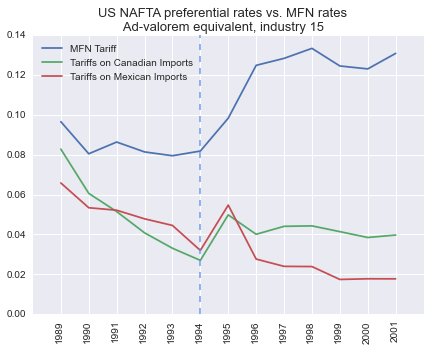

In [10]:
tau_usa_15 = jrt[jrt.hts8 <= 25000000]
tau_usa_s_15 = []
tau_usa_mex_s_15 = []
tau_usa_can_s_15 = []

for t in yr:
    tau_usa_s_15.append(tau_usa_15[tau_usa_15.year==t].mfn_ave.mean())
    tau_usa_can_s_15.append(tau_usa_15[tau_usa_15.year==t].canada_ave.mean())
    tau_usa_mex_s_15.append(tau_usa_15[tau_usa_15.year==t].mexico_ave.mean())

def plot_industry(yr, ind, s, uc, um):
    fig, ax = plt.subplots(figsize=(7,5))   
    ax.plot(yr, s, label = "MFN Tariff")    
    ax.plot(yr, uc, label = "Tariffs on Canadian Imports")
    ax.plot(yr, um, label = "Tariffs on Mexican Imports")
    ax.axvline(x=1994, c = 'cornflowerblue', alpha = 0.8, ls = '--')
    ax.legend(loc=0)
    ax.set_xticks(yr)
    ax.set_xticklabels(yr, rotation = 90)
    fig.suptitle('US NAFTA preferential rates vs. MFN rates\n Ad-valorem equivalent, industry '+str(ind), fontsize=13);
    
plot_industry(yr, 15, tau_usa_s_15, tau_usa_can_s_15, tau_usa_mex_s_15)

Our industry 17 is ISIC Rev. 2 industry 32, Textile, Wearing Apparel and Leather, which corresponds to HTS Section VIII (Leather and Skins, also Articles of Animal Gut OTHER THAN Silkworm Gut, Chapters 41-43), Section XI (textiles and textile articles, Chapters 50-63) and Section XII (footwear, headgear etc., Chapters 64-67). Thus, we construct industry 17 from HTS codes 41000000 to 44000000 and 50000000 to 67000000:

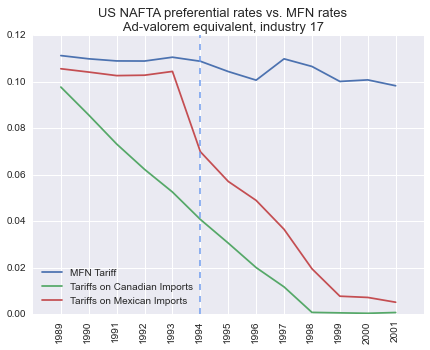

In [11]:
industry_17 = range(int(41e6),int(44e6)) + range(int(50e6),int(67e6))
tau_usa_17 = jrt[jrt.hts8.isin(industry_17)]
tau_usa_s_17 = []
tau_usa_can_s_17 = []
tau_usa_mex_s_17 = []

for t in yr:
    tau_usa_s_17.append(tau_usa_17[tau_usa_17.year==t].mfn_ave.mean())
    tau_usa_mex_s_17.append(tau_usa_17[tau_usa_17.year==t].mexico_ave.mean())
    tau_usa_can_s_17.append(tau_usa_17[tau_usa_17.year==t].canada_ave.mean())
    
plot_industry(yr, 17, tau_usa_s_17, tau_usa_can_s_17, tau_usa_mex_s_17)

Section IX in HTS seems to be a good match for our industry 20, which is ISIC Rev. 2 industry 33 (Wood and Cork). Hence, tariff lines between 44000000 and 47000000 go into industry 20:

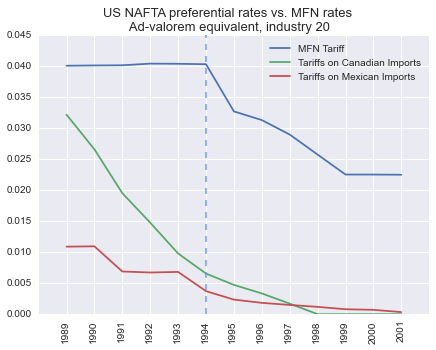

In [12]:
industry_20 = range(int(44e6), int(47e6))
tau_usa_20 = jrt[jrt.hts8.isin(industry_20)]
tau_usa_s_20 = []
tau_usa_can_s_20 = []
tau_usa_mex_s_20 = []

for t in yr:
    tau_usa_s_20.append(tau_usa_20[tau_usa_20.year==t].mfn_ave.mean())
    tau_usa_mex_s_20.append(tau_usa_20[tau_usa_20.year==t].mexico_ave.mean())
    tau_usa_can_s_20.append(tau_usa_20[tau_usa_20.year==t].canada_ave.mean())

plot_industry(yr, 20, tau_usa_s_20, tau_usa_can_s_20, tau_usa_mex_s_20)

The next industry is 20 in our paper, 34 in ISIC Rev. 2, Paper, Printing and Publishing. This seems to be a one-to-one match with Section X of HTS: Pulp of Wood, Paper and Articles Thereof (Chapters 47-49):

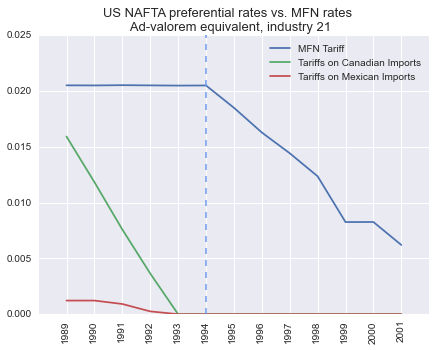

In [13]:
industry_21 = range(int(47e6),int(50e6))
tau_usa_21 = jrt[jrt.hts8.isin(industry_21)]
tau_usa_s_21 = []
tau_usa_can_s_21 = []
tau_usa_mex_s_21 = []

for t in yr:
    tau_usa_s_21.append(tau_usa_21[tau_usa_21.year==t].mfn_ave.mean())
    tau_usa_mex_s_21.append(tau_usa_21[tau_usa_21.year==t].mexico_ave.mean())
    tau_usa_can_s_21.append(tau_usa_21[tau_usa_21.year==t].canada_ave.mean())
    
plot_industry(yr, 21, tau_usa_s_21, tau_usa_can_s_21, tau_usa_mex_s_21)

Industry 23 in our paper is industry 35 in ISIC Rev. 2, Chemical, Petroleum, Coal, Rubber and Plastic Products. This corresponds to Section VI: Products of the Chemical or Allied Industries (Chapters 28-38) and Section VII: Plastics and Rubber (Chapters 39 and 40), but also includes Chapter 27 from Section V: Mineral Products, as this is the Chapter containing Coal and Fuels.

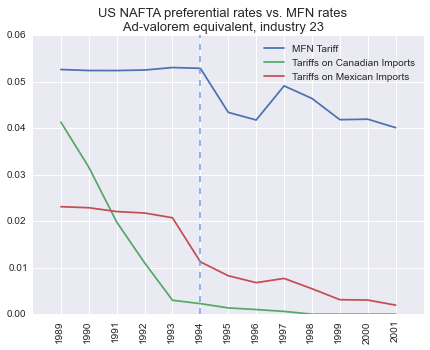

In [14]:
industry_23 = range(int(27e6), int(41e6))
tau_usa_23 = jrt[jrt.hts8.isin(industry_23)]
tau_usa_s_23 = []
tau_usa_can_s_23 = []
tau_usa_mex_s_23 = []

for t in yr:
    tau_usa_s_23.append(tau_usa_23[tau_usa_23.year==t].mfn_ave.mean())
    tau_usa_mex_s_23.append(tau_usa_23[tau_usa_23.year==t].mexico_ave.mean())
    tau_usa_can_s_23.append(tau_usa_23[tau_usa_23.year==t].canada_ave.mean())
    
plot_industry(yr, 23, tau_usa_s_23, tau_usa_can_s_23, tau_usa_mex_s_23)

Industry 26 in our paper is industry 36 in ISIC Rev. 2, Non-Metallic Minerals except Petroleum and Coal. In HTS, this corresponds in all likelihood to  Section XIII: Articles of Stone, Plaster, Cement, Ceramic, Glass (Chapters 68-70), although we could think about chapters 25 and 26 as well, as they are part of Section V: Mineral Products.

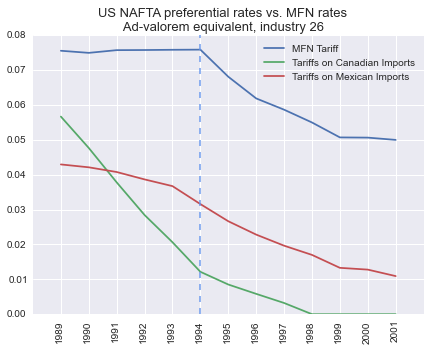

In [15]:
industry_26 = range(int(68e6), int(71e6))
tau_usa_26 = jrt[jrt.hts8.isin(industry_26)]
tau_usa_s_26 = []
tau_usa_can_s_26 = []
tau_usa_mex_s_26 = []

for t in yr:
    tau_usa_s_26.append(tau_usa_26[tau_usa_26.year==t].mfn_ave.mean())
    tau_usa_mex_s_26.append(tau_usa_26[tau_usa_26.year==t].mexico_ave.mean())
    tau_usa_can_s_26.append(tau_usa_26[tau_usa_26.year==t].canada_ave.mean())

plot_industry(yr, 26, tau_usa_s_26, tau_usa_can_s_26, tau_usa_mex_s_26)

Industry 27 in our paper is industry 37 in ISIC Rev. 2: Basic Metals. Here, we have a one-to-one correspondence to Section XV of HTS, Base Metals. This covers chapters 72 to 83:

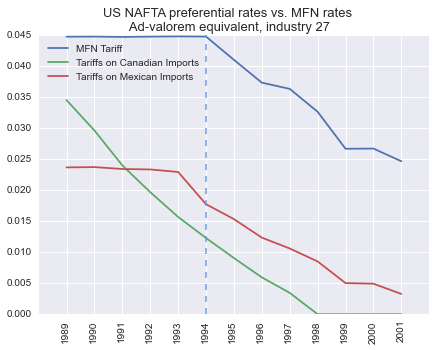

In [16]:
industry_27 = range(int(72e6), int(83e6))
tau_usa_27 = jrt[jrt.hts8.isin(industry_27)]
tau_usa_s_27 = []
tau_usa_can_s_27 = []
tau_usa_mex_s_27 = []

for t in yr:
    tau_usa_s_27.append(tau_usa_27[tau_usa_27.year==t].mfn_ave.mean())
    tau_usa_mex_s_27.append(tau_usa_27[tau_usa_27.year==t].mexico_ave.mean())
    tau_usa_can_s_27.append(tau_usa_27[tau_usa_27.year==t].canada_ave.mean())

plot_industry(yr, 27, tau_usa_s_27, tau_usa_can_s_27, tau_usa_mex_s_27)

The most complicated industry is 28 in our paper, 38 in ISIC Rev.2, Fabricated metal products, machinery and equipment. This category spans Seections XVI (Machinery, Electrical Equipment), Section XVII (Vehicles and Aircraft) and Section XVIII (Optical, photographic, ..., medical instruments, clocks and watches..., BUT excluding musical instruments which according to ISIC is in Manufactuting n.e.c.!). In total, we probably require chapters 84 to 91:

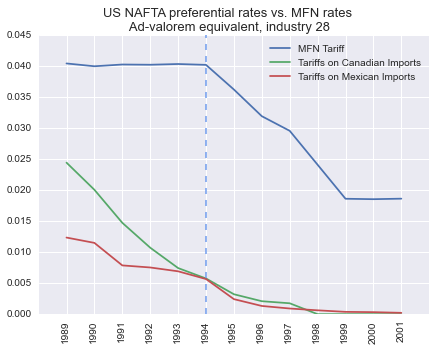

In [17]:
industry_28 = range(int(84e6), int(92e6))
tau_usa_28 = jrt[jrt.hts8.isin(industry_28)]
tau_usa_s_28 = []
tau_usa_can_s_28 = []
tau_usa_mex_s_28 = []

for t in yr:
    tau_usa_s_28.append(tau_usa_28[tau_usa_28.year==t].mfn_ave.mean())
    tau_usa_mex_s_28.append(tau_usa_28[tau_usa_28.year==t].mexico_ave.mean())
    tau_usa_can_s_28.append(tau_usa_28[tau_usa_28.year==t].canada_ave.mean())

plot_industry(yr, 28, tau_usa_s_28, tau_usa_can_s_28, tau_usa_mex_s_28)

Finally, industry 36 in our paper, 39 in ISIC Rev.2, is complicated, as it includes jewellery (which is Section XIV, Chapter 71), musical instruments (Section XVIII, Chapter 92) and Section XX, Miscellaneous. One thing we should keep an eye on is the fact that Furniture moved from being classified as part of the Wood and Cork industry in ISIC Rev.2 to being part of Other Manufacturing/Manufacturing n.e.c. in ISIC Rev.3 (and is there in HTS as well). Section XX covers chapters 94-96, but we might want to move section 94 to industry 20 rather than 36 later on.

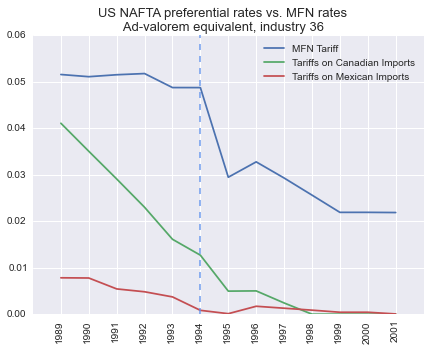

In [18]:
industry_36 = range(int(71e6),int(72e6)) + range(int(92e6), int(93e6)) + range(int(94e6), int(96e6))
tau_usa_36 = jrt[jrt.hts8.isin(industry_36)]
tau_usa_s_36 = []
tau_usa_can_s_36 = []
tau_usa_mex_s_36 = []

for t in yr:
    tau_usa_s_36.append(tau_usa_36[tau_usa_36.year==t].mfn_ave.mean())
    tau_usa_mex_s_36.append(tau_usa_36[tau_usa_36.year==t].mexico_ave.mean())
    tau_usa_can_s_36.append(tau_usa_36[tau_usa_36.year==t].canada_ave.mean())
    
plot_industry(yr, 36, tau_usa_s_36, tau_usa_can_s_36, tau_usa_mex_s_36)

The overall effect of NAFTA on tariff rates across all manufacturing industries is:

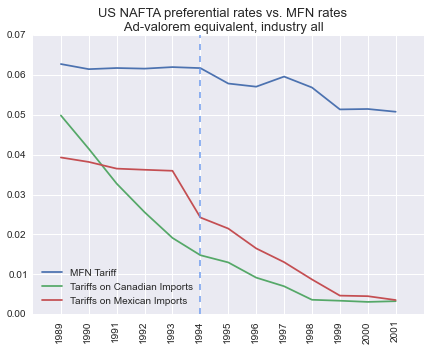

In [19]:
mfn = []
can = []
mex = []
for t in yr:
    mfn.append(jrt[jrt.year==t].mfn_ave.mean())
    mex.append(jrt[jrt.year==t].mexico_ave.mean())
    can.append(jrt[jrt.year==t].canada_ave.mean())
    
plot_industry(yr, "all", mfn, can, mex)

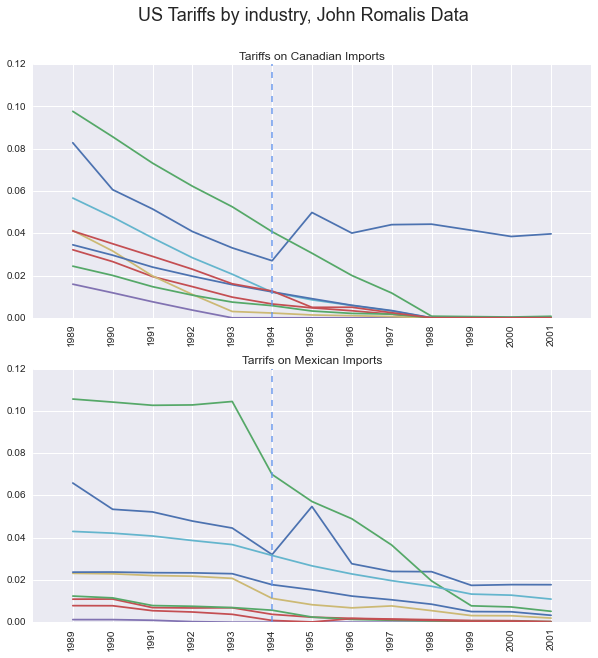

In [20]:
canduty = [tau_usa_can_s_15, tau_usa_can_s_17, tau_usa_can_s_20, tau_usa_can_s_21, tau_usa_can_s_23, 
           tau_usa_can_s_26, tau_usa_can_s_27, tau_usa_can_s_28, tau_usa_can_s_36]
mexduty = [tau_usa_mex_s_15, tau_usa_mex_s_17, tau_usa_mex_s_20, tau_usa_mex_s_21, tau_usa_mex_s_23, 
           tau_usa_mex_s_26, tau_usa_mex_s_27, tau_usa_mex_s_28, tau_usa_mex_s_36]

fig, ax = plt.subplots(2,1, sharey = True, figsize = (10, 10))

for i,industry in enumerate(canduty):
    ax[0].plot(yr, industry, label = industries[i])
ax[0].set_title('Tariffs on Canadian Imports')
ax[0].axvline(x = 1994, c = 'cornflowerblue', alpha = 0.8, ls = '--')
ax[0].set_xticks(yr)
ax[0].set_xticklabels(yr, rotation = 90)
    
for industry in mexduty:
    ax[1].plot(yr, industry)
ax[1].set_title('Tarrifs on Mexican Imports')
ax[1].axvline(x = 1994, c = 'cornflowerblue', alpha = 0.8, ls = '--')
ax[1].set_xticks(yr)
ax[1].set_xticklabels(yr, rotation = 90)

fig.suptitle('US Tariffs by industry, John Romalis Data', fontsize = 18);

<h3>WTO IDB Tariff Data</h3>

The WITS Tariff Database is slightly confusing, to say the least. It offers tariff data from two different sources, the World Bank IDB data base and the UNCTAD TRAINS data base. For each of these two databases, it is also possible to download the data in a number of different nomenclatures (HS, ISIC, SITC...). 

I've downloaded ISIC Rev 2 at the 2 digit (our aggregation) and 4 digit (the lowest level available), as well as the 6 digit level from HS from the WTO IDB database. The analysis below suggests that the tariffs are skewed by one massive outlier, as even the 99th percentile of tariff lines is much much lower than the highest tariff line. 

In [21]:
path = "/Users/"+user+"/Dropbox/Trade Paper/Data/Raw/Tariffs/"

wto_hs = pd.read_csv(path+"WTO_HS_6digit.CSV")
# Drop some unnecessary colums
wto_hs = wto_hs.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1)
# Rename to make life easier
newnames = {'Native Nomen':'nomen', 'Reporter Name':'imp', 'Partner Name':'exp', 'Product':'good',
            'Tariff Year':'year', 'Simple Average':'avg', 'Weighted Average':'wavg', 'Standard Deviation':'std', 
            "Minimum Rate":'minrate', "Maximum Rate":'maxrate', 'Nbr of Total Lines':'lines', 
            "Nbr of DomesticPeaks":'dompeak', "Nbr of InternationalPeaks":'intpeak', 
            'Imports Value in 1000 USD':'value', 'Binding Coverage':'bndcov'}
wto_hs = wto_hs.rename(columns = newnames)

In [22]:
pairs = ["Canada-Mexico", "Canada-United States", "Mexico-Canada", 
 "Mexico-United States", "United States-Canada", "United States-Mexico"]

To better understand what the column names actually mean, it is worthwhile to check out [this](https://www.google.co.uk/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&ved=0CDQQFjADahUKEwidyIfEkYjHAhVIlB4KHcaxDFs&url=http%3A%2F%2Farchive.unu.edu%2Fhq%2Flibrary%2Fresource%2FWITSdoc%2FWITS_Hands_on_Training.ppt&ei=Wd28Vd23CsioesbjstgF&usg=AFQjCNEF2qwyvTm3PGT7ObhRexZWS1Jtsw&sig2=u9PEktzODDccVMVKN9U9hw&bvm=bv.99261572,d.dmo&cad=rja) lengthy PowerPoint presentation with detailed usage instructions for all databases available through WITS. 

A complete breakdown of all variables is available on the [WITS homepage here](http://wits.worldbank.org/wits/wits/witshelp/Content/Data_Retrieval/P/AQ/C9e.AQ_Tariffs-Result.htm). The most important detail for now is the classification of Duty Type as BND for bound tariffs, MFN for MFN applied tariffs, PRF for preferential tariffs or AHS for effectively applied tariffs. As we are only interested in effectively applied tariffs, we can drop the rest of the dataset.

Interestingly, the presentation also details the extent to which trade control measures other than tariffs affect trade in a product category. The UNCTAD coding system records price control (coded as 3), finance (such as advance payment of duties, 4), automatic licensing (5), quantity control (6), monopolistic (7) and techincal (8) protection measures. MFN Applied and Preferential protection data is available in the TRAINS and IDB data bases, although the number of countries is much larger in TRAINS.

The data we just imported comes from the Worldbank's IDB data base, and is recorded in the HS nomenclature. The HS nomenclature was originally devised in 1992 and has gone through four revisions since, which in the IDB data base are called H1 (1996), H2 (2002), H3 (2007) and H4 (2012). Conversion tables are available [here](http://unstats.un.org/unsd/trade/conversions/HS%20Correlation%20and%20Conversion%20tables.htm).

Next, we want to get rid of the product groups we're not interested in. However, the concordance is slightly trickier than expected, and is further complicated by the fact that we have different HS schedules (HS1, HS2, HS3, and HS4).

Hence we actually have to employ the HS to ISIC Rev2 concordance tables from [here](http://wits.worldbank.org/product_concordance.html) to figure out which tariff rates are relevant for us. 

Let's import them:

In [23]:
wto_is2 = pd.read_csv(path+"WTO_ISIC2_2digit.CSV")
wto_is2.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1, inplace=True)
wto_is2.rename(columns = newnames, inplace=True)
wto_is2 = wto_is2[wto_is2.DutyType=="AHS"]

wto_is4= pd.read_csv(path+"WTO_ISIC2_4digit.CSV")
wto_is4.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1, inplace=True)
wto_is4.rename(columns = newnames, inplace=True)
wto_is4 = wto_is4[wto_is4.DutyType=="AHS"]

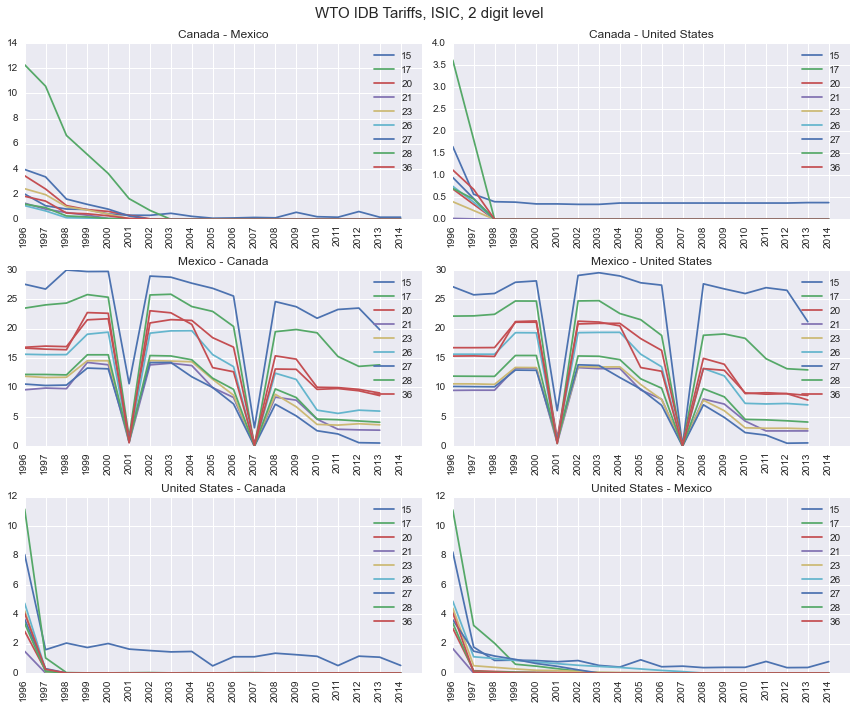

In [24]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    yr = np.sort(wto_is2.year.unique())
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range(31,40)):
        ax.plot(wto_is2[(wto_is2.imp==imp) & (wto_is2.exp==exp) & (wto_is2.good==j)].avg, label = industries[i])
    ax.set_xticks(range(0,len(yr)+1))
    ax.set_xticklabels(yr, rotation = 90)
    ax.legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO IDB Tariffs, ISIC, 2 digit level", fontsize=15);

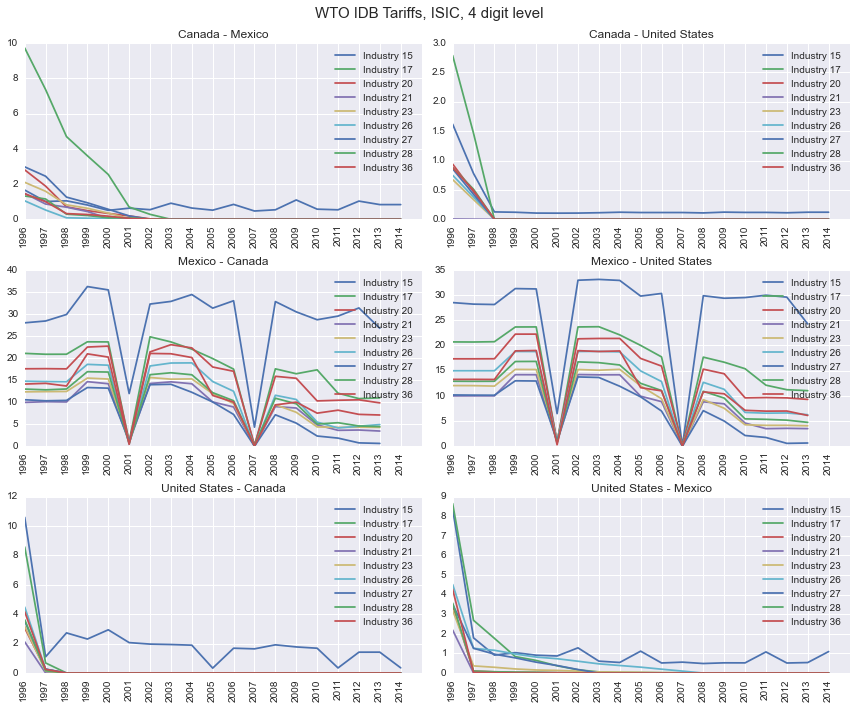

In [25]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range(31,40)):
        subset = wto_is4[(wto_is4.imp==imp) & (wto_is4.exp==exp) & (wto_is4.good>=j*100) & (wto_is4.good<(j+1)*100)] 
        ax.plot(subset.groupby('year').avg.mean(), label = "Industry "+industries[i])
        #ax.plot(subset.groupby('year').avg.max(), label = "Max "+industries[i])
    ax.set_xticks(range(0,len(yr)+1))
    ax.set_xticklabels(yr, rotation = 90)
    ax.legend(loc=0)
        
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO IDB Tariffs, ISIC, 4 digit level", fontsize=15);

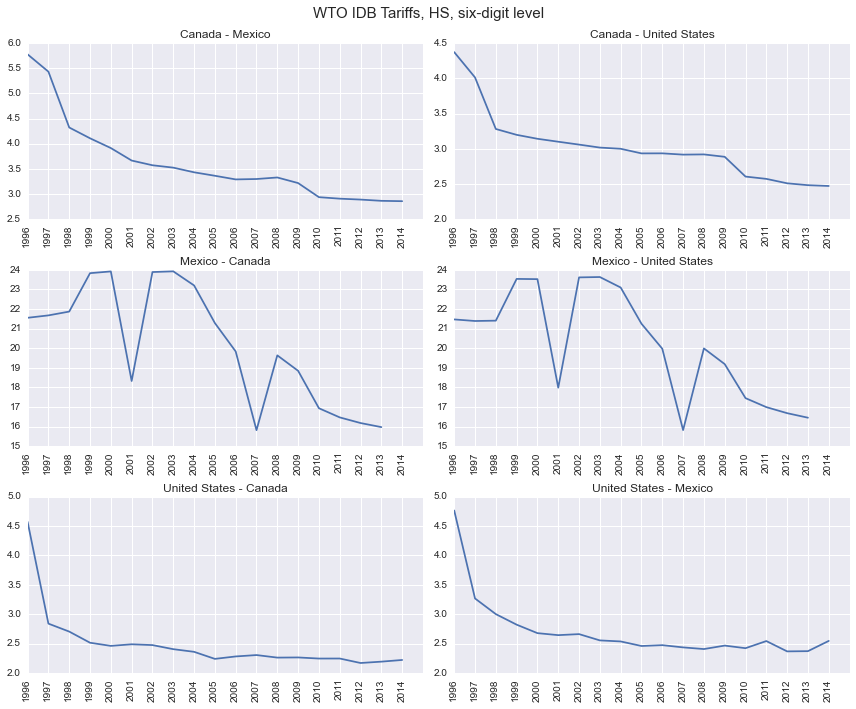

In [26]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_xticklabels(np.linspace(1996,2014,10, dtype=int), rotation = 90)
    ax.set_title(imp+" - "+exp)
    subset = wto_hs[(wto_hs.imp==imp) & (wto_hs.exp==exp)]
    ax.plot(subset.groupby('year').avg.mean())
    ax.set_xticks(range(0,len(yr)+1))
    ax.set_xticklabels(yr, rotation = 90)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO IDB Tariffs, HS, six-digit level", fontsize=15);

What are the product groups with the highest tariffs?

In [27]:
wto_hs[wto_hs.DutyType=='AHS'].groupby(['good', 'imp', 'exp']).mean().sort('avg', ascending=False).iloc[0:6, 0:5]

,,,year,Trade Year,avg,wavg,std
good,imp,exp,,,,,
20900,Mexico,Canada,2004.000000,2004.000000,244.855882,244.855882,11.967647
150100,Mexico,Canada,2004.181818,2004.181818,243.372727,243.372727,0.001818
20712,Mexico,Canada,1997.000000,1997.000000,240.000000,240.000000,0.000000
20726,Mexico,Canada,2000.500000,2000.500000,240.000000,240.000000,0.000000
20735,Mexico,United States,1998.000000,1998.000000,240.000000,240.000000,0.000000
20732,Mexico,United States,2003.500000,2003.500000,237.000000,237.000000,0.000000


<h3>TRAINS tariff data</h3>

The TRAINS tariff data set has the advantage of having MFN, Bound, Applied and Preferential rates available. The question is though why we would want preferential rates if we have applied rates - the only reason this could make a difference is industries for which there is no trade observed, and hence no applied rate, but a preferential rate exists.

A further advantage of the TRAINS dataset is that it goes back further in time, up to 1989 for Canada and the US, and up to 1991 for Mexico. One of the problems though is that there are also some large gaps in the data for earlier periods; for Canada only 1989 and 1993 are available pre-1995, and for Mexico only 1991 is available pre-1995, so that for these two countries there is actually no significant advantage over the WTO IDB data. For the US, all data from 1989 to 2014 is available, with the exception of 1994. 

Importantly, these limitations are the same irrespective of nomenclature used, so it appears that the underlying data is the same for all queries, while the choice of nomenclature just implies different aggregation schemes. 

Import the data:

In [28]:
trains_is2 = pd.read_csv(path+"TRAINS_ISIC_2digit.csv")
trains_is2.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1, inplace=True)
trains_is2.rename(columns = newnames, inplace=True)

Let's start by doing the simple industry plots for AHS (applied) average tariffs, which we also did for the WTO database above:

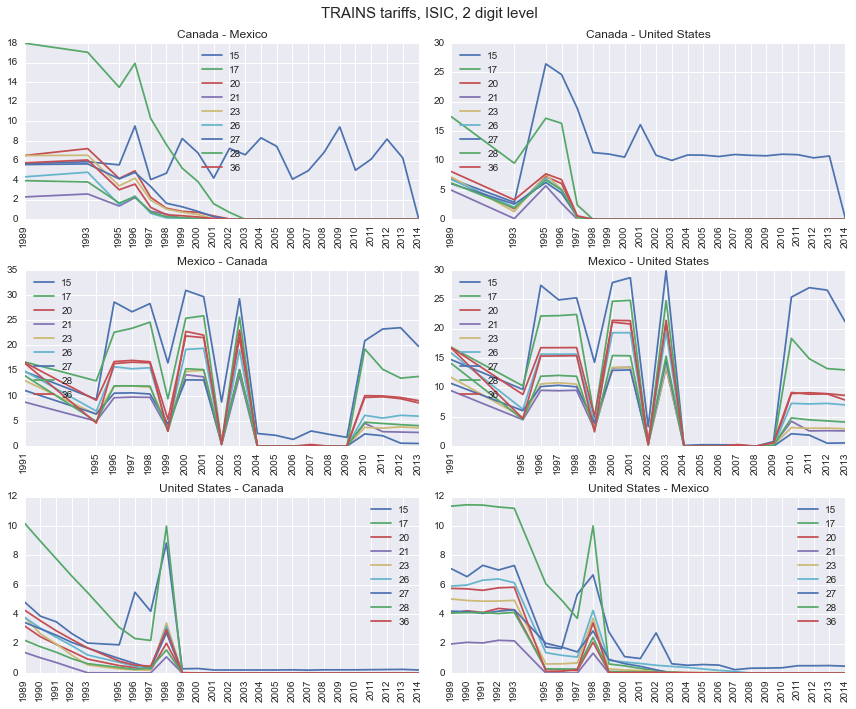

In [29]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range(31,40)):
        yr = np.sort(trains_is2[trains_is2.imp==imp].year.unique())
        subset = trains_is2[(trains_is2.DutyType=="AHS") & (trains_is2.imp==imp) & (trains_is2.exp==exp) & (trains_is2.good==j)]
        ax.plot(yr, subset.avg, label = industries[i])
        ax.set_xticks(yr)
        ax.set_xticklabels(yr, rotation = 90)
    ax.legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("TRAINS tariffs, ISIC, 2 digit level", fontsize=15);

In [30]:
trains_is4 = pd.read_csv(path+"TRAINS_ISIC_4digit.csv")
trains_is4.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1, inplace=True)
trains_is4.rename(columns = newnames, inplace=True)

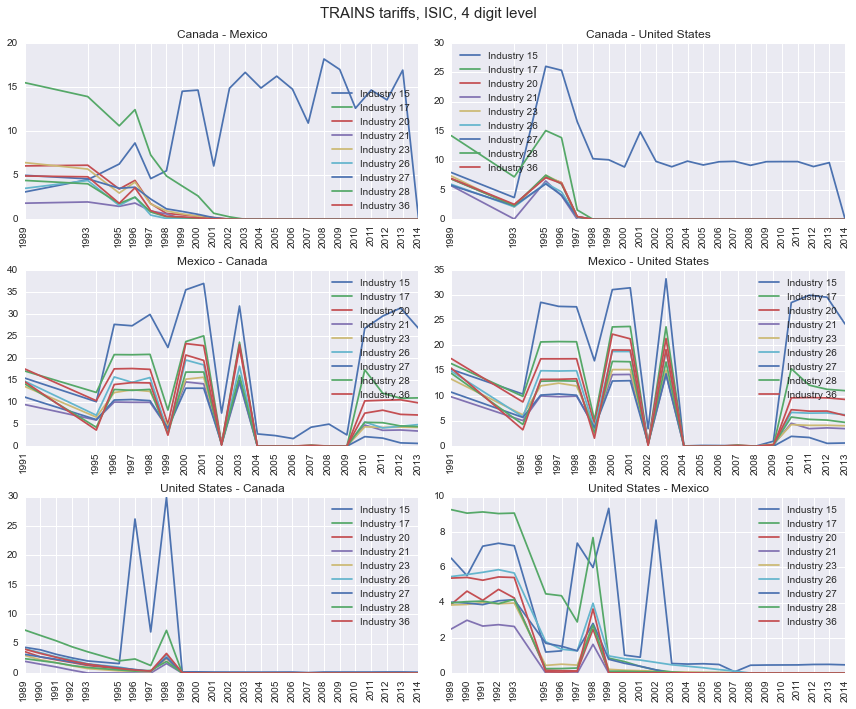

In [31]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range (31,40)):
        yr = np.sort(trains_is4[trains_is4.imp==imp].year.unique())
        subset = trains_is4[(trains_is4.imp==imp) & (trains_is4.exp==exp) & (trains_is4.good>=j*100) & (trains_is4.good<(j+1)*100) & (trains_is4.DutyType=="AHS")] 
        ax.plot(yr, subset.groupby('year').avg.mean(), label = "Industry "+industries[i])
        #ax.plot(subset.groupby('year').wavg.max(), label = "Industry "+industries[i])
        ax.set_xticks(yr)
        ax.set_xticklabels(yr, rotation = 90)
    ax.legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("TRAINS tariffs, ISIC, 4 digit level", fontsize=15);

In [32]:
trains_hs = pd.read_csv(path+"TRAINS_HS_6digit.csv")
trains_hs.drop(['Selected Nomen', 'Reporter', 'Partner', 'Trade Source'], axis=1, inplace=True)
trains_hs.rename(columns = newnames, inplace=True)

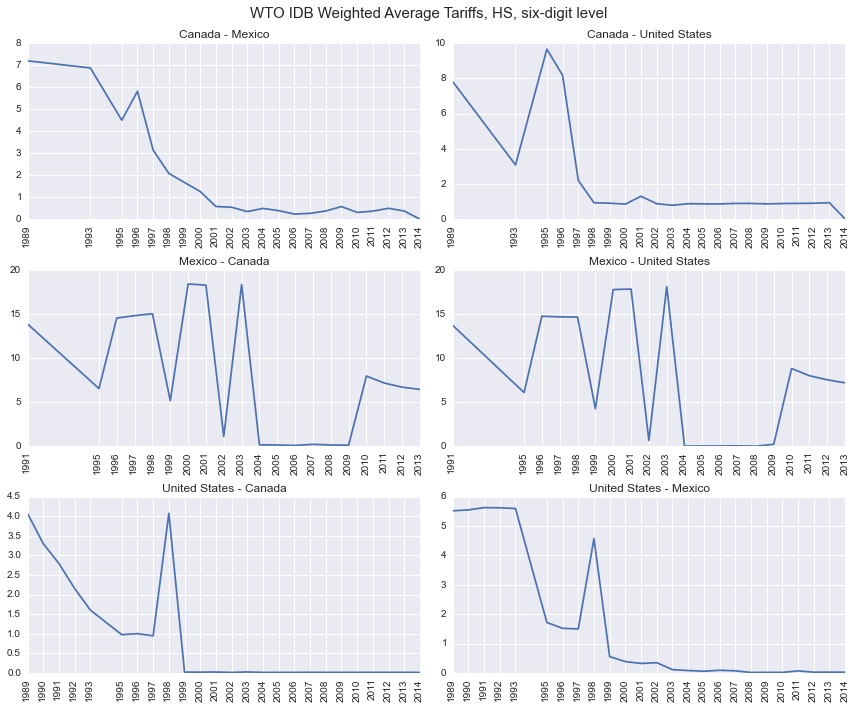

In [33]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    yr = np.sort(trains_hs[trains_hs.imp==imp].year.unique())
    ax.set_xticks(yr)
    ax.set_xticklabels(yr, rotation = 90)
    ax.set_title(imp+" - "+exp)
    subset = trains_hs[(trains_hs.imp==imp) & (trains_hs.exp==exp) & (trains_hs.DutyType=="AHS")]
    ax.plot(yr, subset.groupby('year').avg.mean())
    #ax.plot(subset.groupby('year').wavg.max(), label = "Maximum Tariff")
    #ax.plot(subset.groupby('year').wavg.quantile(0.99))
    #ax.plot(subset.groupby('year').wavg.quantile(0.95))
    #ax.plot(subset.groupby('year').wavg.quantile(0.90))

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO IDB Weighted Average Tariffs, HS, six-digit level", fontsize=15);

<h3>Some Comparisons</h3>

<h4>1. WTO IDB vs. TRAINS, 2 digit level</h4>

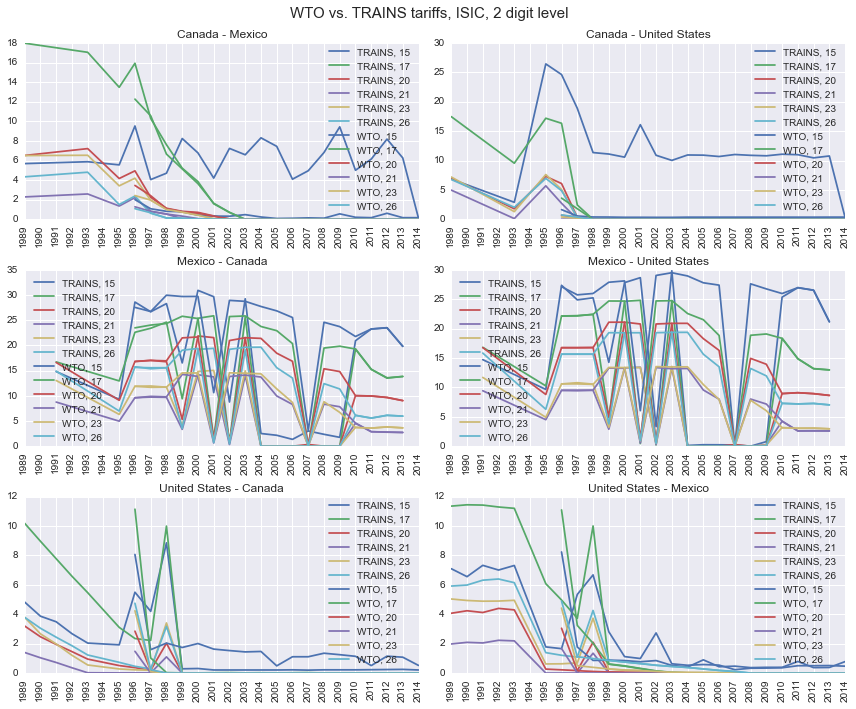

In [34]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range(31,37)):
        yr_t = np.sort(trains_is2[trains_is2.imp==imp].year.unique())
        subset_t = trains_is2[(trains_is2.DutyType=="AHS") & (trains_is2.imp==imp) & (trains_is2.exp==exp) & (trains_is2.good==j)]
        ax.plot(yr_t, subset_t.avg, label = "TRAINS, "+industries[i])
    for i,j in enumerate(range(31,37)):
        subset_w = wto_is2[(wto_is2.DutyType=="AHS") & (wto_is2.imp==imp) & (wto_is2.exp==exp) & (wto_is2.good==j)]
        yr_w = np.sort(wto_is2[wto_is2.imp==imp].year.unique())
        ax.plot(yr_w, subset_w.avg, label = "WTO, "+industries[i])
        ax.set_xticks(range(1989, 2015))
        ax.set_xticklabels(range(1989, 2015), rotation = 90)
    ax.legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO vs. TRAINS tariffs, ISIC, 2 digit level", fontsize=15);

<h4>WTO ISIC 2 digit vs 4 digit</h4>

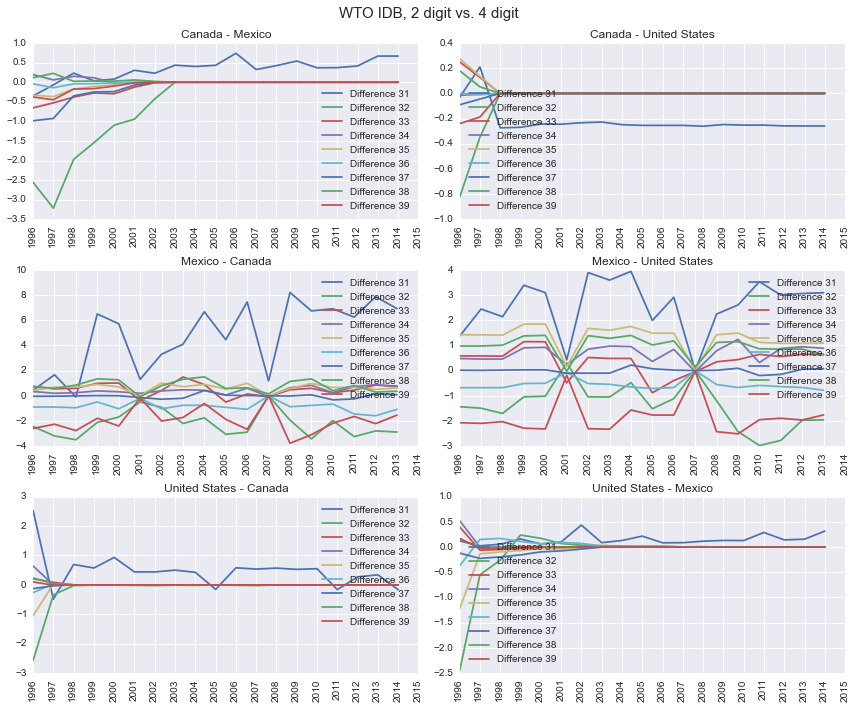

In [35]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

for i, ax in enumerate(ax.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    ax.set_title(imp+" - "+exp)
    for i,j in enumerate(range (31,40)):
        subset = wto_is4[(wto_is4.imp==imp) & (wto_is4.exp==exp) & (wto_is4.good>=j*100) & (wto_is4.good<(j+1)*100) & (wto_is4.DutyType=="AHS")] 
        diff = subset.groupby('year').avg.mean().values-wto_is2[(wto_is2.imp==imp)&(wto_is2.exp==exp)&(wto_is2.good==j)].avg.values
        ax.plot(range(1996, len(diff)+1996), diff, label = "Difference "+str(j))
    ax.set_xticks(range(1996, len(diff)+1996+1))
    ax.set_xticklabels(range(1996, len(diff)+1996+1), rotation = 90)
    ax.legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("WTO IDB, 2 digit vs. 4 digit", fontsize=15);

<h4>Smooth out Mexican jumps in 2001 and 2007</h4>

In [36]:
def smooth_mex(df):
    for exp in ["Canada", "United States"]:
        for yr in [2001, 2007]:
            x1 = df.loc[(df.imp=="Mexico") & (df.exp==exp) & (df.year==yr-1), 'avg']
            x2 = df.loc[(df.imp=="Mexico") & (df.exp==exp) & (df.year==yr+1), 'avg']
            df.loc[(df.imp=="Mexico") & (df.exp==exp) & (df.year==yr), 'avg'] = (x1.values+x2.values)/2
            
smooth_mex(wto_is2)

<h4>TRAINS AHS vs TRAINS PRF vs WTO AHS</h4>

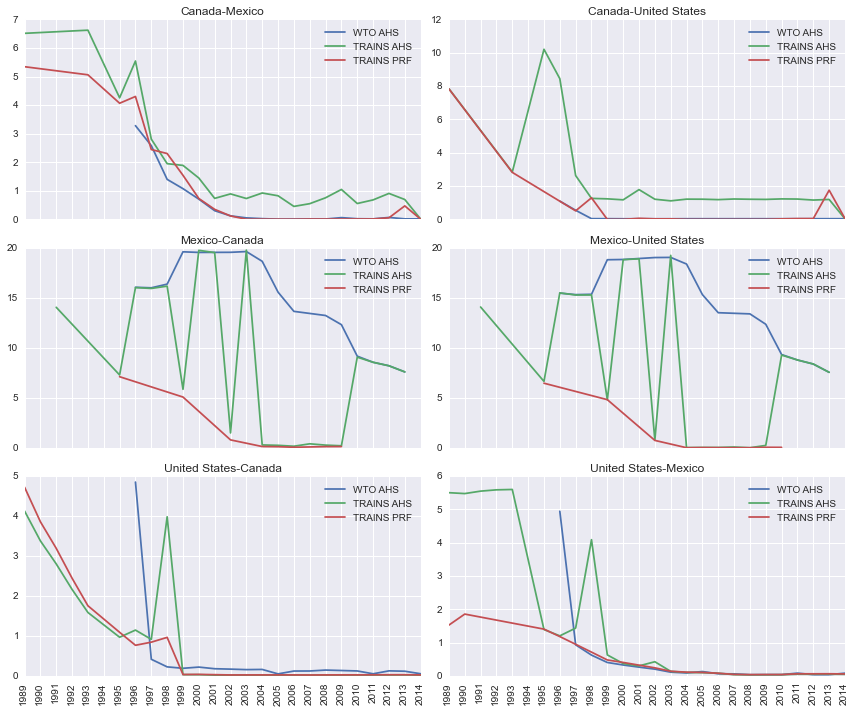

In [37]:
fig, axes = plt.subplots(3,2, figsize=(12,10), sharex = True)
for i, ax in enumerate(axes.reshape(-1)):
    imp = pairs[i].split('-')[0]
    exp = pairs[i].split('-')[1]
    subset = wto_is2[(wto_is2.imp==imp)& (wto_is2.exp==exp)]
    yrs = np.sort(subset.year.unique())
    ax.plot(yrs, subset.groupby('year').mean().avg, label = "WTO AHS")
    subset = trains_is2[(trains_is2.imp==imp)& (trains_is2.exp==exp) & (trains_is2.DutyType=="AHS")]
    yrs = np.sort(subset.year.unique())
    ax.plot(yrs, subset.groupby('year').mean().avg, label = "TRAINS AHS")
    subset = trains_is2[(trains_is2.imp==imp)& (trains_is2.exp==exp) & (trains_is2.DutyType=="PRF")]
    yrs = np.sort(subset.year.unique())
    ax.plot(yrs, subset.groupby('year').mean().avg, label = "TRAINS PRF")
    ax.set_xticks(range(1989,2015))
    ax.set_xticklabels(range(1989,2015), rotation = 90)
    ax.legend(loc=0)
    ax.set_title(imp+"-"+exp)
    
fig.tight_layout()

<h3>Data for export</h3>

Based on the above, the proposal is to create a data set which uses mostly TRAINS preferential tariff data, but supplements it with observations from TRAINS or WTO IDB applied tariffs where appropriate. This leads to the following rules for construction:

- <b>Canada</b>: TRAINS PRF from 1989 to 1995, WTO AHS from 1996 to 2014 
      [can-mex: 89,93,95-13, can-usa: 89,93,96-13]
- <b>Mexico</b>: TRAINS AHS from 1989 to 1994, TRAINS PRF from 1995 to 2009 
      [mex-can: 91,95,99,02,04,05,06,08,09, mex-usa: 91,95,99,02,04,05,06,08,09,10]
- <b>USA</b>: TRAINS PRF for 1989 to 1996, WTO AHS for 1997 to 2014 
      [usa-can: 89-93,95-14, usa-mex: 89,90,95-14]

In [38]:
years = range(1989, 2015)

export = pd.DataFrame({"year": list(np.tile(years, len(industries)*3)),
    "imp":list(np.repeat("Canada", len(years)*len(industries)*2)) + list(np.repeat("Mexico", len(years)*len(industries))),
    "obs_id":list(np.repeat(range(1,28), len(years))),
    "exp":list(np.repeat("Mexico",len(years)*len(industries)))+list(np.repeat("United States",len(years)*len(industries)*2)),
    "good": list(np.repeat(np.tile(range(31,40), 3),len(years)))
    })

# Function to quickly create datasets for merging:
def create_merge(df, imp, dutytype, start, end):
    to_merge = df[(df.imp==imp) & (df.DutyType==dutytype) & (df.year.isin(range(start, end+1)))]
    to_merge = to_merge[['imp', 'exp', 'good', 'year', 'avg', 'wavg']]
    return to_merge

# Canada: 1989-1995 TRAINS PRF, 1996-2014 WTO AHS
can1 = create_merge(trains_is2, "Canada", "PRF", 1989, 1995)
can2 = create_merge(wto_is2, "Canada", "AHS", 1996, 2014)

# Mexico: 1989-1994 TRAINS AHS, 1995, 2009 TRAINS PRF
mex1 = create_merge(trains_is2, "Mexico", "AHS", 1989, 1994)
mex2 = create_merge(trains_is2, "Mexico", "PRF", 1995, 2014)

# USA: 1989-1996 TRAINS PRF, 1997-2014 WTO AHS
usa1 = create_merge(trains_is2, "United States", "PRF", 1989, 1996)
usa2 = create_merge(wto_is2, "United States", "AHS", 1997, 1998)
usa3 = create_merge(trains_is2, "United States", "PRF", 1999, 2014)

export = pd.merge(export, can1, on=["imp", "exp", "good", "year"], how="left")

In [39]:
def mergecombine(df1, df2):
    new = pd.merge(df1, df2, on=["imp", "exp", "good", "year"], how="left")
    new.loc[~np.isfinite(new.avg_x), 'avg_x'] = new[~np.isfinite(new.avg_x)].avg_y
    new.loc[~np.isfinite(new.wavg_x), 'wavg_x'] = new[~np.isfinite(new.wavg_x)].wavg_y
    new.rename(columns = {"avg_x":"avg", "wavg_x":"wavg"}, inplace=True)
    new.drop(["avg_y", "wavg_y"], 1, inplace=True)
    return new

In [40]:
for df in [can2, mex1, mex2, usa1, usa2]:
    export = mergecombine(export, df)

In [41]:
export.rename(columns = {'avg':'tau_s_h', 'wavg':'tau_w_h'}, inplace = True)
export['tau_s_f'] = np.NaN
export['tau_w_f'] = np.NaN

In [42]:
def mergecombine_f(df1, df2):
    new = pd.merge(df1, df2, left_on=['imp', 'exp', 'good', 'year'], right_on=['exp', 'imp', 'good', 'year'], how="left")
    new.loc[np.isfinite(new.avg), 'tau_s_f'] = new[np.isfinite(new.avg)].avg
    new.loc[np.isfinite(new.wavg), 'tau_w_f'] = new[np.isfinite(new.wavg)].wavg
    new.rename(columns = {'imp_x':'imp', 'exp_x':'exp'}, inplace = True)
    new.drop(['imp_y', 'exp_y', 'avg', 'wavg'], 1, inplace = True)
    return new

In [43]:
for df in [mex1, mex2, usa1, usa2, usa3]:
    export = mergecombine_f(export, df)

In [44]:
export = export[['obs_id', 'imp', 'exp', 'good', 'year', 'tau_s_h', 'tau_s_f', 'tau_w_h', 'tau_w_f']]
export.rename(columns = {'imp': 'market_h', 'exp': 'market_f'}, inplace=True)

<h3>Final dataset for export (with linear interpolation)</h3>

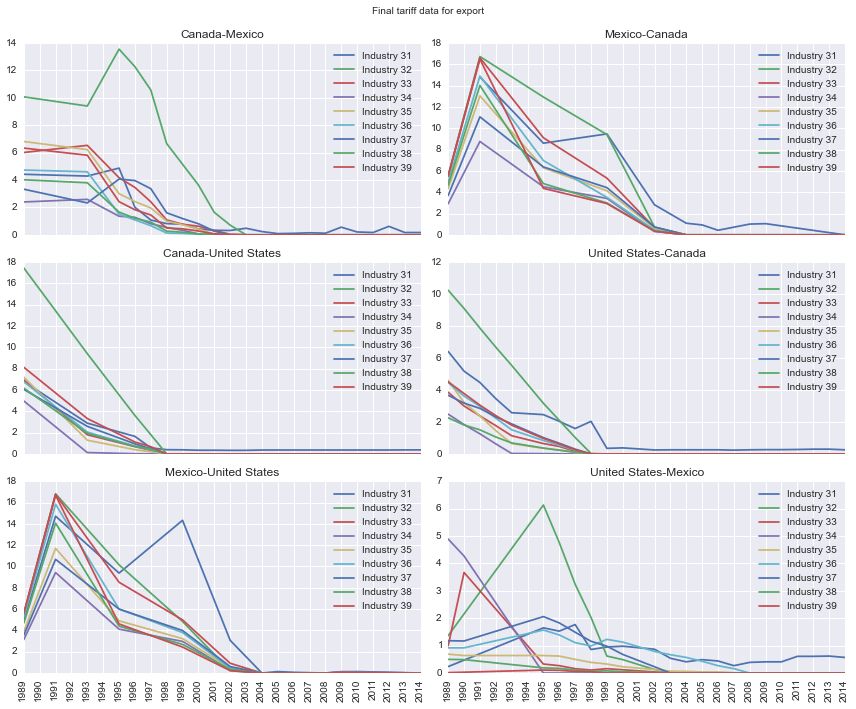

In [45]:
intp = export
intp.loc[(intp.year==2014)&(intp.market_h=="Mexico"), ['tau_s_h','tau_w_h']] = 0
intp.loc[(intp.year==2014)&(intp.market_f=="Mexico"), ['tau_s_f','tau_w_f']] = 0
intp = export.interpolate()
pairs = ['Canada-Mexico','Canada-United States','Mexico-United States']
fig, axes = plt.subplots(3,2, sharex=True, figsize=(12,10))
yr = range(1989, 2015)
for i in range(0,3):
    market_h = pairs[i].split('-')[0]
    market_f = pairs[i].split('-')[1]
    for j in range(31,40):
        subset = intp[(intp.market_h==market_h) & (intp.market_f==market_f) & (intp.good==j)]
        axes[i,0].plot(yr, subset.tau_s_h, label = "Industry "+str(j))
        axes[i,1].plot(yr, subset.tau_s_f, label = "Industry "+str(j))
    axes[i,0].set_title(market_h+"-"+market_f)
    axes[i,1].set_title(market_f+"-"+market_h)
    axes[i,0].set_xticks(yr)
    axes[i,1].set_xticks(yr)
    axes[i,0].set_xticklabels(yr, rotation = 90)
    axes[i,1].set_xticklabels(yr, rotation = 90)
    axes[i,0].legend(loc=0)
    axes[i,1].legend(loc=0)

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("Final tariff data for export");

In [52]:
export[(export.market_h=='Canada') & (export.market_f=='Mexico') & (export.year==1991)].mean()

obs_id        5.000000
good         35.000000
year       1991.000000
tau_s_h            NaN
tau_s_f      14.047778
tau_w_h            NaN
tau_w_f      11.591111
dtype: float64

(Note: we are exporting the data with `NaN` values, the interpolation was just done for the plots!)

In [46]:
export.to_csv("/Users/"+user+"/Dropbox/Trade Paper/Data/Raw/Tariffs/tariffs_final.csv", index=False)